# Contributor Dynamics & Development Patterns in Open-Source Projects: A Case Study of the RustDesk GitHub Repository

## John Ian Haviland
### March 10, 2024

### Abstract

The objective of this report is to analyze the contribution dynamics of the RustDesk GitHub repository. Using GitHub's API, I was able to mine data that held the details of closed pull requests. The analysis was designed to uncover trends in contributions, identify major contributors, and highlight the common themes in pull requests. My findings show fluctuating activity with distinct peaks of contribution over time, a concentration of contribution among top contributors, and the project development's prevalent topics.


### Introduction

Through a comprehensive analysis of pull request data, I'll delve into the RustDesk project's collaborative development environment, where my goals are to:

* Determine the project's activity level and identify any significant trends/patterns.
* Recognize the key contributors to the project.
* Ascertain prevalent themes and focus areas in development discussions.

This analysis stands to benefit those interested in the project's workflow efficency, as well as the project's maintainers and contributors.

The methods employed include data extraction (via GitHub's API), data cleaning, statistical analysis, and visualizations using multiple Python libraries.

In [14]:
import requests
import csv
import logging
from datetime import datetime

# Configuration
OPENAI_API_KEY = "your-openai-api-key-here"
GITHUB_API_URL = "https://api.github.com/repos/"
REPO_NAME = "rustdesk/rustdesk"
TOKEN = "your-github-api-token-here"
HEADERS = {"Authorization": f"token {TOKEN}"}
MAX_PULL_REQUESTS = 4000

def check_token_validity():
    response = requests.get("https://api.github.com/user", headers=HEADERS)
    if response.status_code == 200:
        print("Token is valid. User:", response.json()['login'])
    elif response.status_code == 401:  # Unauthorized
        print("Token is invalid or expired.")
    else:
        print(f"Failed to validate token. Status code: {response.status_code}")

check_token_validity()

Token is valid. User: johnhaviland


### Background

RustDesk, an open-source remote desktop application, is built primarily in Rust, which allows remote access and maintenance of devices across multiple platforms. Positioning itself as an open-source alternative to established desktop solutions, it emphasizes ease of use without necessitating complex network setups like VPNs. The project's GitHub repository is a central point of development, and it reflects active participation from a global community. Pull requests reveal updates across localization, feature enhancement, and system compatibility.

In [7]:
# Logging setup
logging.basicConfig(filename='app_activity.log', level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

def fetch_closed_pull_requests(repo_name, max_prs):
    """Fetches a list of closed pull requests from a repository."""
    pull_requests = []
    page = 1
    while len(pull_requests) < max_prs:
        url = f"{GITHUB_API_URL}{repo_name}/pulls?state=closed&per_page=100&page={page}"
        response = requests.get(url, headers=HEADERS)
        if response.status_code != 200:
            logging.error(f"Failed to fetch closed PRs: {response.status_code}")
            break
        data = response.json()
        if not data:
            break  # No more PRs to fetch
        pull_requests.extend(data)
        page += 1
    return pull_requests[:max_prs]

def extract_pr_details(prs):
    """Extracts and returns details from pull requests."""
    pr_details = []
    for pr in prs:
        pr_number = pr['number']
        issue_number = pr.get('issue_url', '').split('/')[-1]
        commit_date = pr['created_at']
        author = pr['user']['login']
        title = pr['title']
        body = pr['body']
        comments_url = pr['comments_url']
        
        # Fetch comments
        comments_response = requests.get(comments_url, headers=HEADERS)
        comments = comments_response.json() if comments_response.status_code == 200 else []
        
        # Assume the last commenter closes the PR
        closer = comments[-1]['user']['login'] if comments else None
        
        # Fetch files associated with the PR
        files_response = requests.get(pr['url'] + '/files', headers=HEADERS)
        files = files_response.json() if files_response.status_code == 200 else []
        file_names = [file['filename'] for file in files]
        
        pr_details.append({
            'pr_number': pr_number,
            'issue_number': issue_number,
            'commit_date': commit_date,
            'author': author,
            'title': title,
            'body': body,
            'closer': closer,
            'files': ", ".join(file_names)
        })
        
        logging.info(f"Processed PR #{pr_number}")
    return pr_details

def save_to_csv(data, filename):
    """Saves PR details to a CSV file."""
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        fieldnames = ['pr_number', 'issue_number', 'commit_date', 'author', 'title', 'body', 'closer', 'files']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

def main():
    logging.info("Script started")
    closed_prs = fetch_closed_pull_requests(REPO_NAME, MAX_PULL_REQUESTS)
    logging.info(f"Fetched {len(closed_prs)} closed PRs")
    pr_details = extract_pr_details(closed_prs)
    save_to_csv(pr_details, 'pr_details.csv')
    logging.info("Script completed. PR details saved to pr_details.csv")

if __name__ == "__main__":
    main()

### Analysis

##### Pull Requests Over Time

The time-series visualization shows the number of pull requests submitted to the repository each month, highlighting periods of heightened activities and potential project milestones. 

Takeaways:

* A gradual increase in activity since the inception of the dataset (March 2021).
* Major spikes in contributions from about May 2022 onwards. These spikes are likely to correspond to major updates or community events.
* Peaks in November 2022, February 2023, March 2023 (highest peak), and August 2023, which indicate key project milestones such as critical bug fixes, new feature releases, or enhancements made by the community.
* A high level of activity extending into 2024 (March data is incomplete, as the last pull request is from March 9, 2024). This suggests that the project still remains highly active and continues to attract contributions.

C:\Users\jhavi\AppData\Local\Temp\ipykernel_36644\24058506.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.resample('M', on='commit_date').size().plot(label='Monthly PRs', color='blue')


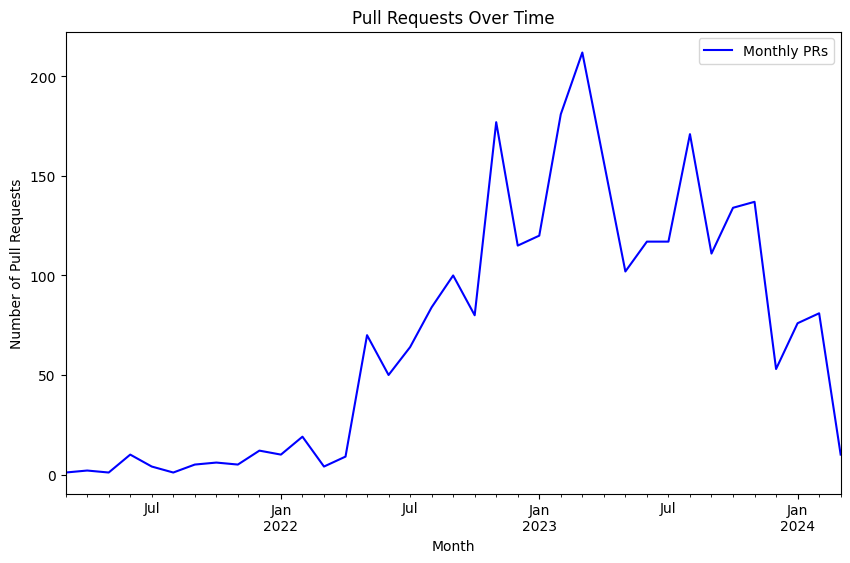

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('pr_details.csv')

# Convert commit_date to datetime
data['commit_date'] = pd.to_datetime(data['commit_date'])

# Plotting
plt.figure(figsize=(10, 6))
data.resample('M', on='commit_date').size().plot(label='Monthly PRs', color='blue')
plt.title('Pull Requests Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Pull Requests')
plt.legend()
plt.show()

#### Pull Requests by Top Contributors

This bar chart reveals the distribution of contributions, identifying the twenty-five most active contributors to the project. This visual helps recognize the individuals who have had a significant impact on the development of the project.

The main takeaway from this chart is that there is a visible spread in the number of contributions, with a steep drop-off from the most active contributors to others. This is a pattern that is common in open-source projects, though, as there is usually a core group that contributes the majority of the work.

C:\Users\jhavi\AppData\Local\Temp\ipykernel_36644\895229404.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_contributors.index, y=top_contributors.values, palette=palette)


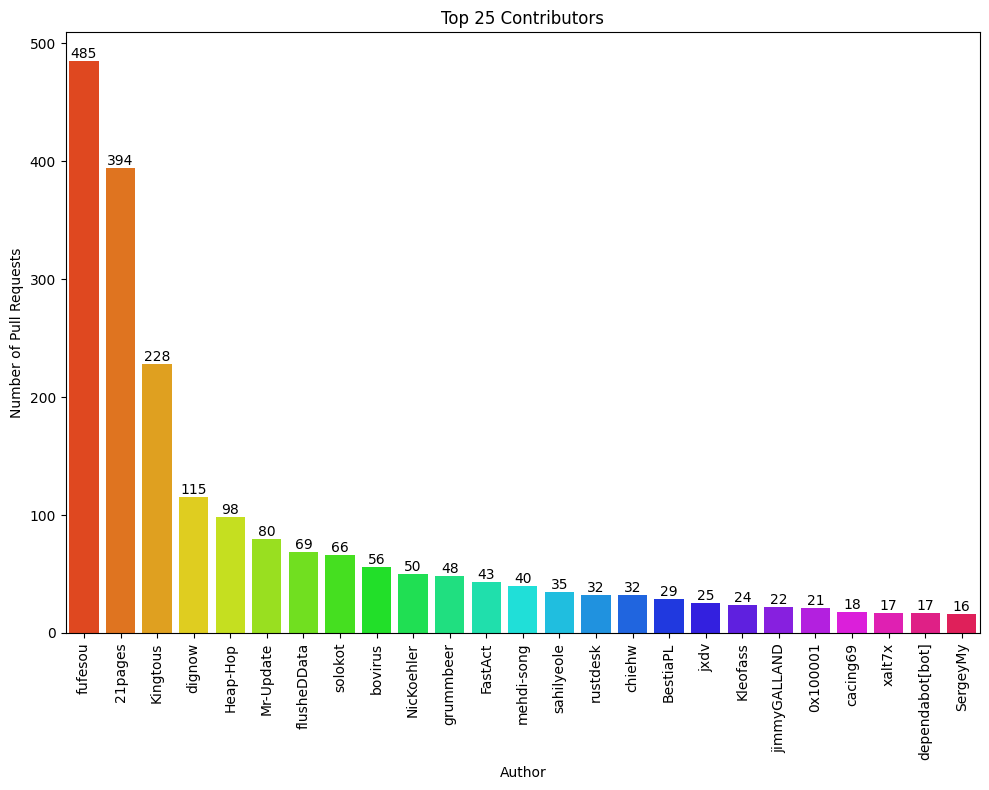

In [45]:
plt.figure(figsize=(10, 8))

palette = sns.color_palette("hsv", len(top_contributors))

sns.barplot(x=top_contributors.index, y=top_contributors.values, palette=palette)

for i, value in enumerate(top_contributors.values):
    plt.text(i, value, f'{value}', ha='center', va='bottom')

plt.title('Top 25 Contributors')
plt.xlabel('Author')
plt.xticks(rotation=90)
plt.ylabel('Number of Pull Requests')

plt.tight_layout()
plt.show()

#### Word Cloud of Pull Request Titles

The word cloud (as well as the list of the most common words) created from pull request titles indicates the most frequent topics of discussion, illustrating the primary focus ideas in the project's development.

Takeaways:

* The frequent appearance of words like "update" (704 occurrences) and "fix" (611 occurrences) shows a strong emphasis on maintaining and enhancing the existing functionalities within the project. This implies that the RustDesk project actively addresses bugs and updates features to ensure reliability.

* The use of "add" (195 occurrences) and "feat" (109 occurrences) (short for "feature") so frequently in the pull requests indicate efforts to introduce new features/capabilities to the software.

* The words "flutter" (105 occurrences) and "windows" (78 occurrences) possibly indicate discussions around the Flutter UI framework and Windows operating system (or perhaps, about window management as well), respectively. This shows active development and optimization efforts, as well as attention to cross-platform compatibility and UI design.

* Words used in the pull requests such as "translation" (92 occurrences) and "language" (77 occurrences) reflect the project's commitment to making the RustDesk software more accessible to a global audience.

In [46]:
from collections import Counter
import re

titles_string = ' '.join(data['title'])

processed_titles = re.sub(r'[^a-zA-Z0-9\s]', '', titles_string.lower())

words = processed_titles.split()

word_counts = Counter(words)

most_common_words = word_counts.most_common(20)

most_common_words

[('update', 704),
 ('fix', 611),
 ('add', 195),
 ('to', 171),
 ('on', 148),
 ('for', 142),
 ('and', 127),
 ('feat', 109),
 ('flutter', 105),
 ('window', 105),
 ('in', 96),
 ('translation', 92),
 ('opt', 86),
 ('rurs', 81),
 ('windows', 78),
 ('remove', 78),
 ('language', 77),
 ('ders', 76),
 ('when', 74),
 ('the', 71)]

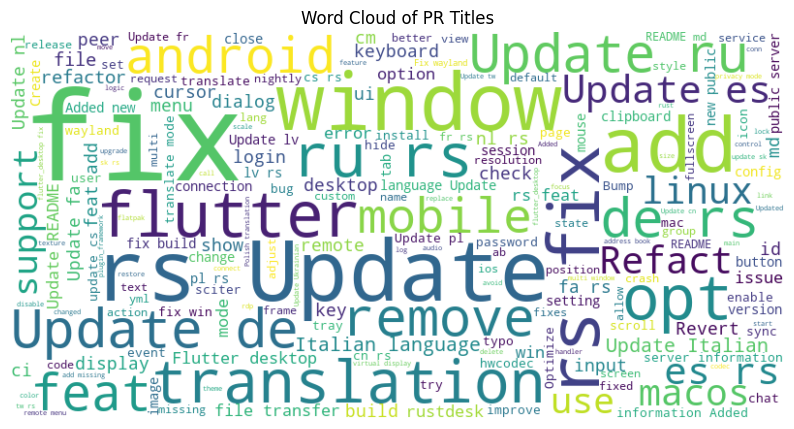

In [47]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(titles_string)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of PR Titles')
plt.show()

### References

https://github.com/rustdesk/rustdesk

https://rustdesk.com/index.html